## Data Prepocessing 

Import Library

In [30]:
# library for data analysis
import numpy as np
import pandas as pd

# library for data visualization 
import matplotlib.pyplot as plt 
import seaborn as sns
from wordcloud import WordCloud
from collections import Counter

# library for content-based filtering
from sklearn.feature_extraction.text import TfidfVectorizer 
from sklearn.metrics.pairwise import cosine_similarity 
from sklearn.model_selection import train_test_split

# library for collaborative filtering 
import tensorflow 
import keras
from tensorflow.keras.models import Model 
from tensorflow.keras.layers import Input, Embedding, Dot, Flatten

# library for ignore 'warnings'
import os 
import warnings


In [31]:
dataset_dir = './dataset/'

In [32]:
# load dataset 
destination = pd.read_csv( os.path.join(dataset_dir, 'tourism_with_id.csv') )
rating = pd.read_csv(os.path.join(dataset_dir, 'tourism_rating.csv'))
user = pd.read_csv(os.path.join(dataset_dir, 'user.csv'))

In [33]:
print(f'number of tourist destination = {len(destination.Place_Id.unique())}')
print(f'number of user = {len(user.User_Id.unique())}')

number of tourist destination = 437
number of user = 300


In [34]:
destination = destination.drop(['Coordinate', 'Time_Minutes'], axis=1)
destination.head(2)

,Place_Id,Place_Name,Description,Category,City,Price,Rating,Lat,Long
0,1,Monumen Nasional,Monumen Nasional atau yang populer disingkat d...,Budaya,Jakarta,20000,4.6,-6.17539,106.8272
1,2,Kota Tua,"Kota tua di Jakarta, yang juga bernama Kota Tu...",Budaya,Jakarta,5000,4.6,-6.13764,106.8171


In [35]:
destination.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 437 entries, 0 to 436
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Place_Id     437 non-null    int64  
 1   Place_Name   437 non-null    object 
 2   Description  437 non-null    object 
 3   Category     437 non-null    object 
 4   City         437 non-null    object 
 5   Price        437 non-null    int64  
 6   Rating       437 non-null    float64
 7   Lat          437 non-null    float64
 8   Long         437 non-null    float64
dtypes: float64(3), int64(2), object(4)
memory usage: 30.9+ KB


In [36]:
# merge rating dataset with destination dataset on Place_Id column 
full = pd.merge(rating, destination[['Place_Id', 'Place_Name', 'Category', 'Description']], on = 'Place_Id',
                        how = 'left')
full.head(2)

,User_Id,Place_Id,Place_Ratings,Place_Name,Category,Description
0,1,179,3,Candi Ratu Boko,Budaya,Situs Ratu Baka atau Candi Boko (Hanacaraka:ê¦...
1,1,344,2,Pantai Marina,Bahari,Pantai Marina (bahasa Jawa: ê¦¥ê¦±ê¦¶ê¦±ê¦¶ê¦‚...


In [37]:
# merge full dataset (destination & rating) with user dataset (age's column)
merged_df = pd.merge(full, user, on='User_Id')

In [38]:
merged_df= merged_df.drop(['Location'], axis = 1)

In [39]:
merged_df.head(2)

,User_Id,Place_Id,Place_Ratings,Place_Name,Category,Description,Age
0,1,179,3,Candi Ratu Boko,Budaya,Situs Ratu Baka atau Candi Boko (Hanacaraka:ê¦...,20
1,1,344,2,Pantai Marina,Bahari,Pantai Marina (bahasa Jawa: ê¦¥ê¦±ê¦¶ê¦±ê¦¶ê¦‚...,20


In [40]:
merged_df.sort_values('Place_Ratings', ascending= False).drop_duplicates(subset=['Place_Id', 'User_Id'])

,User_Id,Place_Id,Place_Ratings,Place_Name,Category,Description,Age
7644,230,396,5,Monumen Kapal Selam,Budaya,"Monumen Kapal Selam, atau disingkat Monkasel, ...",20
8383,253,117,5,The World Landmarks - Merapi Park Yogyakarta,Taman Hiburan,Merapi Park merupakan salah satu tempat wisata...,34
6426,193,428,5,Monumen Bambu Runcing Surabaya,Budaya,Monumen Bambu Runcing adalah ikon pariwisata S...,20
8406,253,158,5,Pantai Pok Tunggal,Bahari,"Pantai Pok Tunggal atau biasa disebut ""the hid...",34
8405,253,149,5,Goa Cerme,Cagar Alam,Gua Cerme (bahasa Jawa: ê¦’ê¦¸ê¦®â€‹ê¦•ê¦ºê¦‚ê...,34
...,...,...,...,...,...,...,...
7496,226,298,1,Gunung Lalakon,Cagar Alam,Gunung Lalakon merupakan sebuah gunung yang te...,23
2684,83,394,1,Air Mancur Menari,Taman Hiburan,Jembatan Kenjeran dengan air mancur menarinya ...,32
2681,83,152,1,Pantai Patihan,Bahari,"Pantai ini terletak di daerah Srigading, Sande...",32
7506,226,105,1,Candi Donotirto,Budaya,"Walaupun melekat dengan kata candi, Candi Dono...",23


In [41]:
# check null values oe merged_df 
merged_df.isnull().sum()

User_Id          0
Place_Id         0
Place_Ratings    0
Place_Name       0
Category         0
Description      0
Age              0
dtype: int64

### Exploratory Data Analysis (EDA)

Visulization 1

In [42]:
popular_rating = rating['Place_Id'].value_counts().reset_index()[0:10]

In [43]:
popular_rating.head(2)

,Place_Id,count
0,177,39
1,298,39


In [44]:
destination.head(2)

,Place_Id,Place_Name,Description,Category,City,Price,Rating,Lat,Long
0,1,Monumen Nasional,Monumen Nasional atau yang populer disingkat d...,Budaya,Jakarta,20000,4.6,-6.17539,106.8272
1,2,Kota Tua,"Kota tua di Jakarta, yang juga bernama Kota Tu...",Budaya,Jakarta,5000,4.6,-6.13764,106.8171


In [45]:
popular_rating = popular_rating.merge(destination[['Place_Id', 'Place_Name']])

In [46]:
popular_rating.head(2)

,Place_Id,count,Place_Name
0,177,39,Pantai Parangtritis
1,298,39,Gunung Lalakon


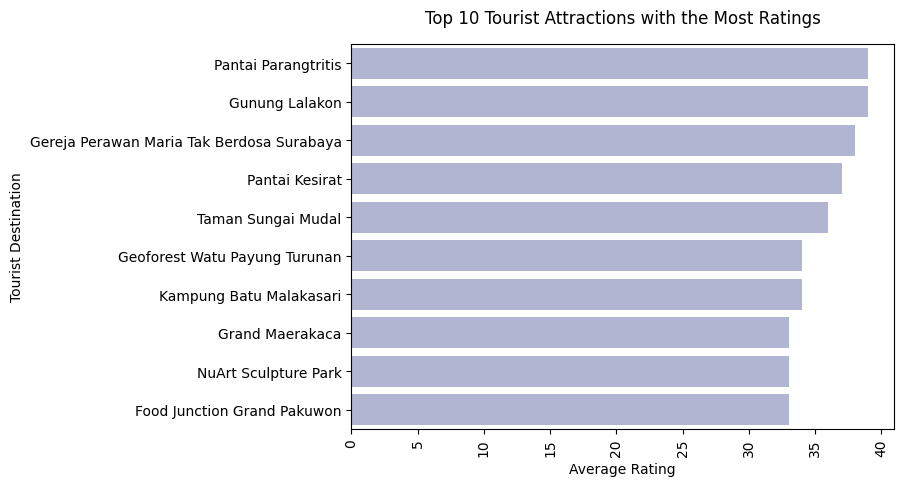

In [48]:
# A graph of tourist destination with the highest number of ratings
plt.figure(figsize=(7,5))
sns.barplot(x='count', y='Place_Name', data = popular_rating, color = '#ACB1D6')

plt.title('Top 10 Tourist Attractions with the Most Ratings', pad=15)
plt.xlabel('Average Rating')
plt.ylabel('Tourist Destination')
plt.xticks(rotation = 90)
plt.show()

Visualization 2

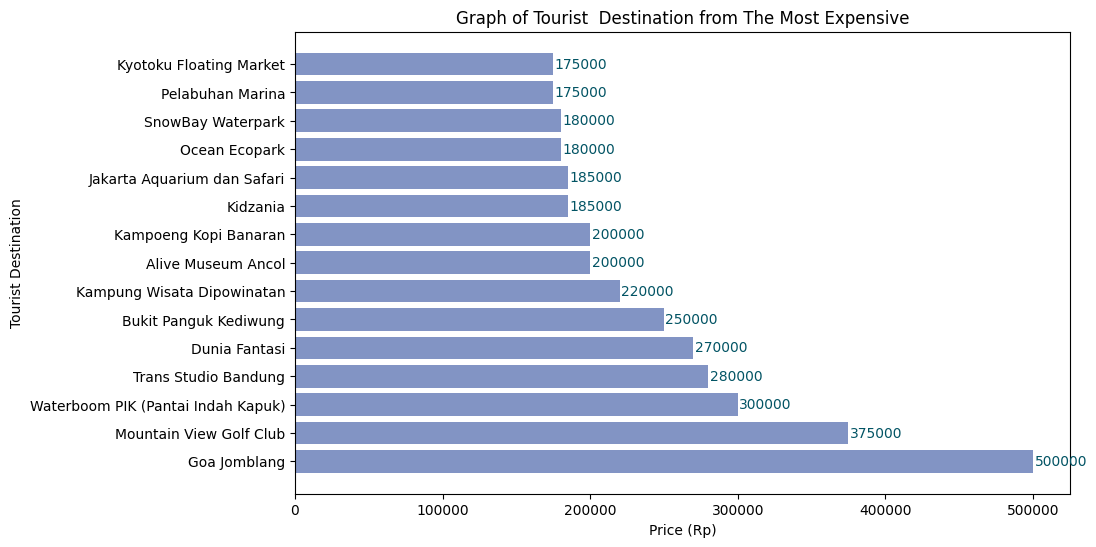

In [49]:
import matplotlib.pyplot as plt 

plt.figure(figsize = (10, 6))
place_name= destination['Place_Name']
price= destination['Price']

data_sorted = sorted(zip(place_name, price), key=lambda x: x[1], reverse = True)
data_sorted = data_sorted[:15] 

place_name_sorted, price_sorted = zip(*data_sorted)
plt.barh(place_name_sorted, price_sorted, color = '#8294C4')

# add label (price)
for i, v in enumerate(price_sorted):
  plt.text(v + 1000, i, str(v), color = '#025464', va= 'center' )


plt.xlabel('Price (Rp)')
plt.ylabel('Tourist Destination')
plt.title('Graph of Tourist  Destination from The Most Expensive')
plt.show()

Visulaization 3

(-1.25, 1.25, -1.25, 1.25)

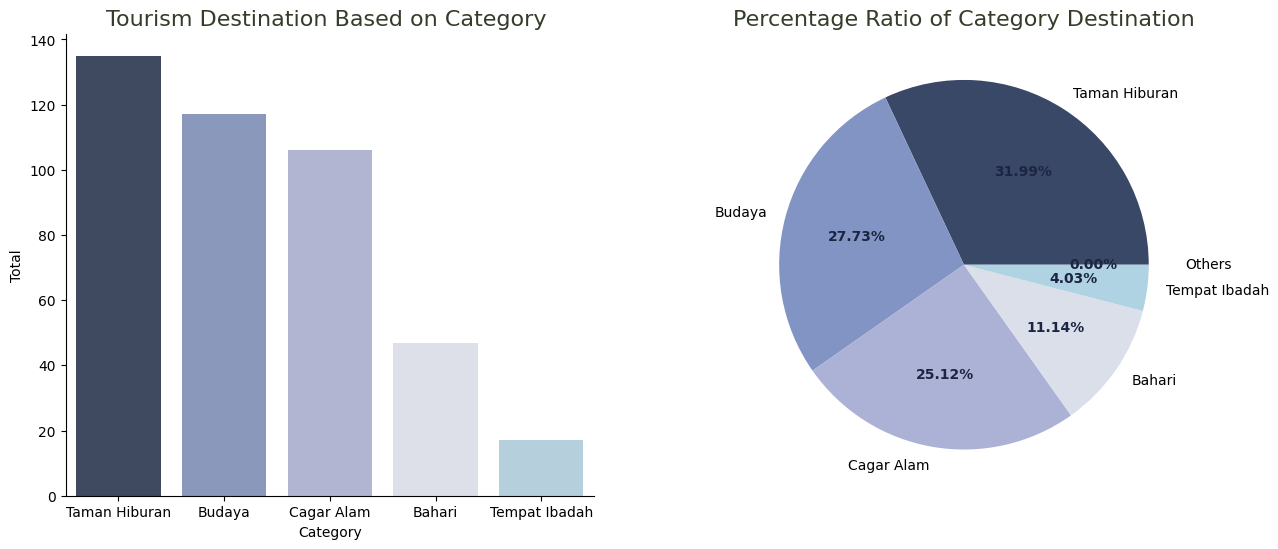

In [50]:
# graph to see the distribution of tourist attractions by category
from collections import Counter

category_list = []
for i in destination['Category']:
    category_list.extend(i.split(', '))

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,6))

df_plot = pd.DataFrame(Counter(category_list).most_common(5), columns=['Category', 'Total'])
ax = sns.barplot(data=df_plot, x='Category', y='Total', ax=axes[0], palette=['#394867', '#8294C4', '#ACB1D6', '#DBDFEA', '#AFD3E2'])
ax.set_title('Tourism Destination Based on Category ', fontsize=16, weight=450, color='#333d29')
sns.despine()

df_plot_full = pd.DataFrame([Counter(category_list)]).transpose().sort_values(by=0, ascending=False)
df_plot.loc[len(df_plot)] = {'Category': 'Others', 'Total':df_plot_full[6:].sum()[0]}
plt.title('Percentage Ratio of Category Destination', fontsize=16, weight= 450, color='#333d29')
wedges, texts, autotexts = axes[1].pie(x=df_plot['Total'], labels=df_plot['Category'], autopct='%.2f%%',
                                       textprops=dict(fontsize=10), explode=[0,0,0,0,0,0.1], colors=['#394867', '#8294C4', '#ACB1D6', '#DBDFEA', '#AFD3E2', '#146C94'])

for autotext in autotexts:
    autotext.set_color('#1c2541')
    autotext.set_weight('bold')

axes[1].axis('off')

Visulaization 4

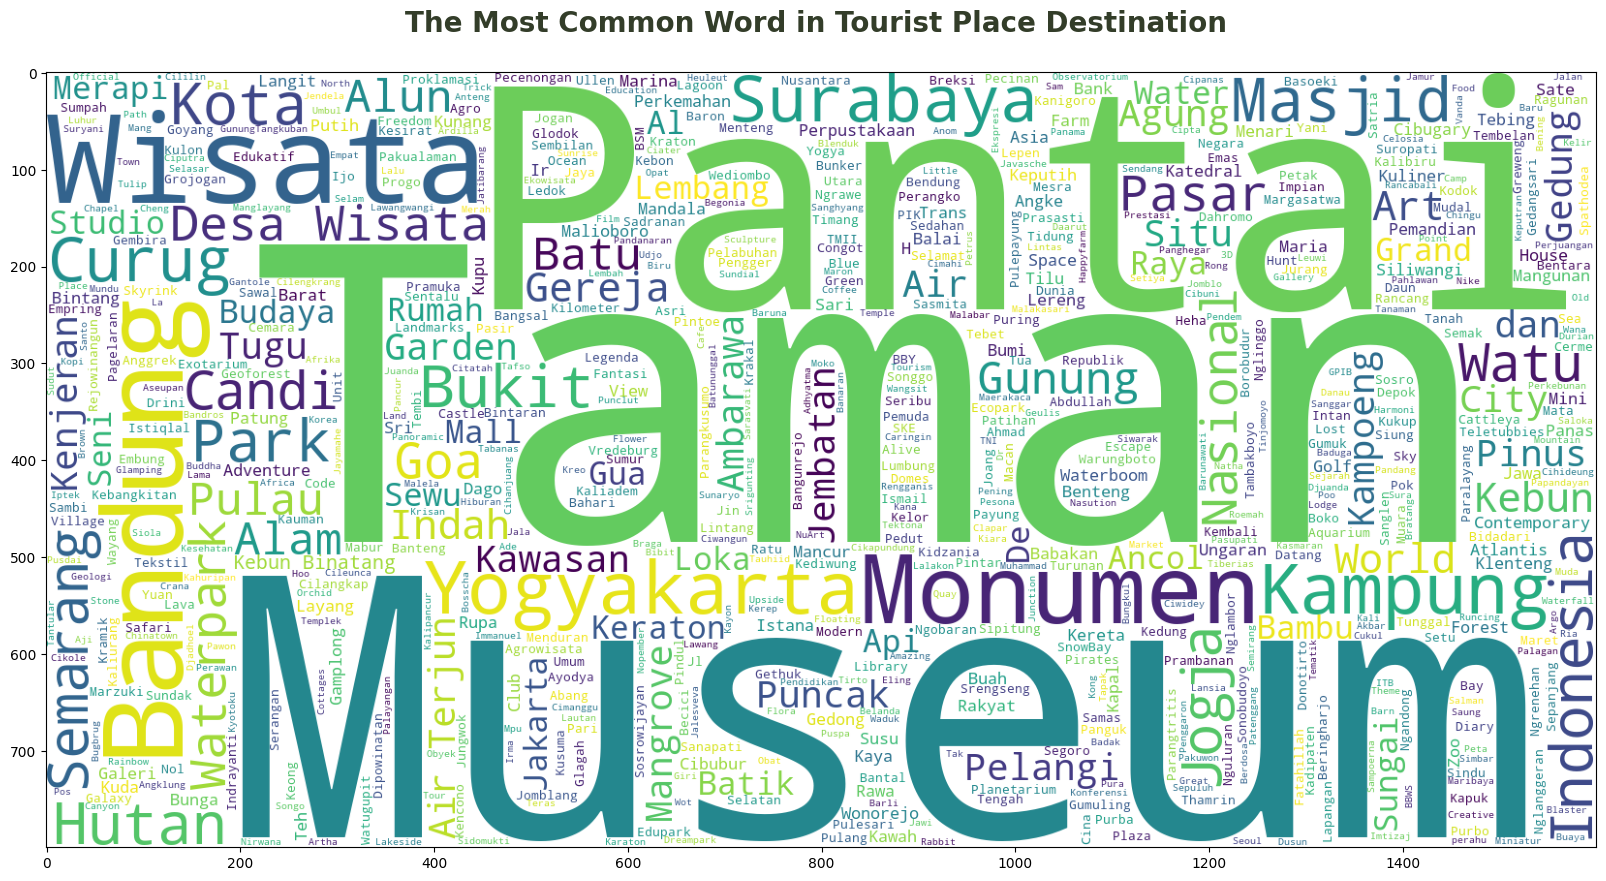

In [51]:
# visualization to see the words that appear most frequently
from wordcloud import WordCloud

plt.figure(figsize=(20,20))
plt.title('The Most Common Word in Tourist Place Destination \n', fontsize=20, weight=600, color='#333d29')
word_cloud = WordCloud(max_words=1000, min_font_size=10,
                height=800,width=1600,background_color="white").generate(' '.join(destination['Place_Name']))

plt.imshow(word_cloud)